In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

HAS_LATEX = False
def dxdt(x, y, sigma=10):
    return sigma * (y - x)

def dydt(x, y, z, rho=28):
    return x * (rho - z) - y

def dzdt(x, y, z, beta=8/3):
    return x * y - beta * z

def RK2(x0, y0, z0, time_steps, dt, show_progress_bar = True):
    n = round(time_steps / dt)
    y = y0
    x = x0
    z = z0
    hist = []
    if show_progress_bar:
        iterator = tqdm(range(1, n+1))
    else:
        iterator = range(1, n+1)
    for i in iterator:
        hist.append([x, y, z])
        xk1 = dxdt(x, y)
        yk1 = dydt(x, y, z)
        zk1 = dzdt(x, y, z)
        xk2 = dxdt(x + xk1 * dt, y + yk1 * dt)
        yk2 = dydt(x + xk1 * dt, y + yk1 * dt, z + zk1 * dt)
        zk2 = dzdt(x + xk1 * dt, y + yk1 * dt, z + zk1 * dt)
        x += (xk1 + xk2) / 2 * dt
        y += (yk1 + yk2) / 2 * dt
        z += (zk1 + zk2) / 2 * dt
    
    return np.array(hist)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def ly_exp_lin(t, a, lyp):
    return a + lyp * t

def ly_exp(t, a, lyp):
    return np.exp(ly_exp_lin(t, a, lyp))


In [10]:
dt = 0.0001; time_steps = 15; epsilon = 1e-9; coords0 = (2,3,-14)

def find_trajectory_distances(dt, time_steps, epsilon, coords0, show_pb = True):
    x0, y0, z0 = coords0
    hist1 = RK2(x0, y0, z0, time_steps, dt, show_progress_bar = show_pb)
    hist2 = RK2(x0, y0, z0 + epsilon, time_steps, dt, show_progress_bar = show_pb)
    # dist = sqrt(dx^2 + dy^2 + dz^2)
    distances = np.sqrt((np.abs(hist1 - hist2) ** 2).sum(axis = 1))
    return hist1, hist2, distances

hist1, hist2, distances = find_trajectory_distances(dt, time_steps, epsilon, coords0)
log_dist = np.log(distances)


  0%|          | 0/150000 [00:00<?, ?it/s]

100%|██████████| 150000/150000 [00:00<00:00, 297906.28it/s]


In [11]:
params, cv = curve_fit(ly_exp_lin, np.linspace(0, time_steps, round(time_steps / dt)), log_dist, [epsilon, 0.8])

Text(0.5, 0, 'Z Axis')

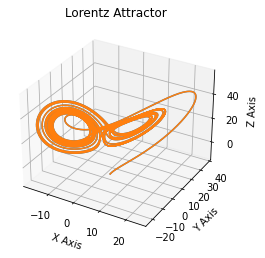

In [12]:
plt.figure(1)
ax = plt.axes(projection='3d')
ax.plot(*hist1.T)
ax.plot(*hist2.T)
ax.set_title('Lorentz Attractor')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')


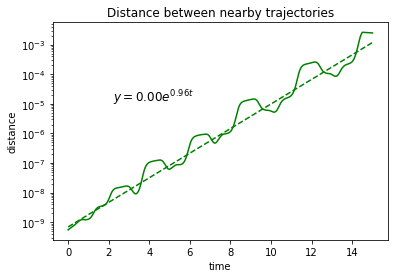

In [13]:
def plot_distance_between_nearby_trajectories(distances):
    plt.figure()
    ax = plt.axes()
    ax.set_yscale('log')
    window = 1000
    ax.plot(np.linspace(0, time_steps, round(time_steps / dt)), moving_average(distances, 10000), 'g')
    plt.title('Distance between nearby trajectories')
    plt.xlabel('time')
    plt.ylabel('distance')
    xs = np.linspace(0, time_steps, round(time_steps / dt))
    ys = [ly_exp(t, *params) for t in xs]
    ax.plot(xs, ys, 'g--')
    equation_string = f'$y={np.exp(params[0]):.2f}e^{{{params[1]:.2f}t}}$'
    plt.text(0.3, 0.7, equation_string, horizontalalignment='center',
        verticalalignment='top', transform=ax.transAxes, usetex=HAS_LATEX, fontsize=12) 
plot_distance_between_nearby_trajectories(distances)

Vary initial values to see how robust this exponent is

In [14]:
def find_distances(starting_coords:list):
    exponents = []
    for coords0 in tqdm(starting_coords):
        hist1, hist2, distances = find_trajectory_distances(dt, time_steps, epsilon, coords0, show_pb=False)
        log_dist = np.log(distances) 
        xs = np.linspace(0, time_steps, round(time_steps / dt))
        params, cv = curve_fit(ly_exp_lin, xs, log_dist, [epsilon, 0.8])
        if not np.isfinite(np.sum(cv)):
            exponents.append(None)
            continue
        # ssr = np.sum(np.square(log_dist - (params[1] * xs + params[0]))) #sum squared regression
        # sst = np.sum(log_dist - np.mean(log_dist)) #Total sum of squares
        # r2 = 1 - (ssr / sst) #Coeff. of determination
        # if r2 < 0.5:
        #     exponents.append(None)
        #     continue
     
        exponents.append(params[1])
    return exponents

In [15]:
#Generate random coordinate values in sphere
radius = 14
n = 500
starting_coords = (2 * np.random.rand(n, 3) - 1) * radius
#sphere filled with random points

13.97223971851881
13.99486689373716
13.977530050275822
0.32036970462866443
0.1906075821587769
0.3405940043989799


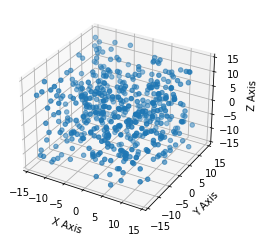

In [16]:
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*starting_coords.T)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
print(max(starting_coords[:,0]))
print(max(starting_coords[:,1]))
print(max(starting_coords[:,2]))
print(np.mean(starting_coords[:,0]))
print(np.mean(starting_coords[:,1]))
print(np.mean(starting_coords[:,2]))


In [17]:
# 10 ^ 3 = 1000 iterations
exponents = find_distances(starting_coords)

  0%|          | 0/500 [00:00<?, ?it/s]

  2%|▏         | 10/500 [00:23<19:24,  2.38s/it]


KeyboardInterrupt: 

In [ ]:
# export to file
np.save('./exponents.npy', np.array(exponents), allow_pickle=True)

In [18]:
# import from file
exponents = np.load('./exponents.npy', allow_pickle=True)

(array([ 23.,   9.,   6.,   8.,   8.,   9.,   7.,   9.,  14.,  14.,  24.,
         28.,  33.,  73., 112.,  87.,  19.,  12.,   3.,   2.]),
 array([0.08687053, 0.1425375 , 0.19820448, 0.25387146, 0.30953844,
        0.36520541, 0.42087239, 0.47653937, 0.53220635, 0.58787332,
        0.6435403 , 0.69920728, 0.75487426, 0.81054123, 0.86620821,
        0.92187519, 0.97754216, 1.03320914, 1.08887612, 1.1445431 ,
        1.20021007]),
 <BarContainer object of 20 artists>)

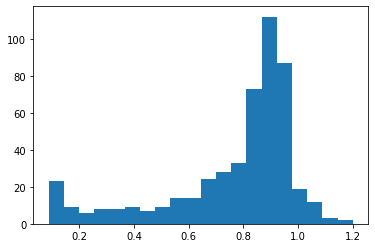

In [19]:
plt.figure(3)
for i in range(len(exponents)):
    if exponents[i] is None:
        exponents[i] = -1
plt.hist(exponents, bins=20)


Plot the various exponents

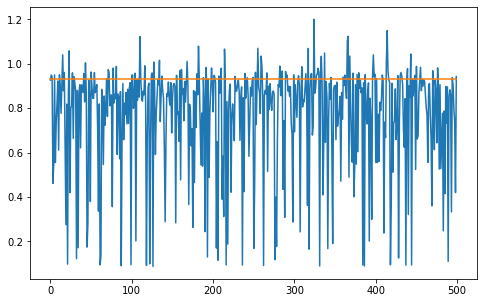

In [20]:
plt.figure(4, figsize=(8,5))
plt.plot(exponents)
plt.plot([0.93] * len(exponents))

Plot distance from orgin / lyapunov exponent graph

Text(0, 0.5, 'Exponent')

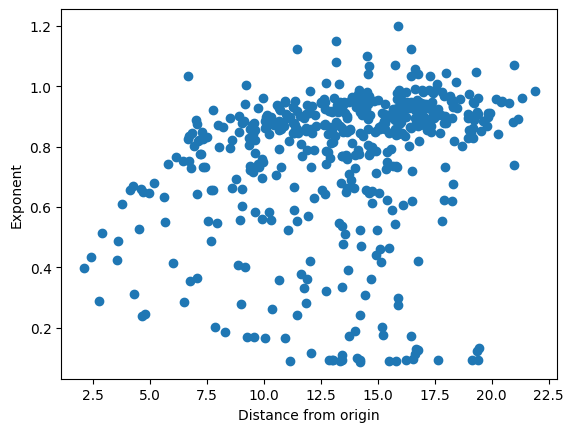

In [ ]:
xs = []

for i, exponent in enumerate(exponents):
    coord = starting_coords[i] 
    distance_from_origin = np.sqrt(sum([c ** 2 for c in coord]))
    xs.append(distance_from_origin)

plt.figure(5)
plt.scatter(xs, exponents)
plt.xlabel('Distance from origin')
plt.ylabel('Exponent')


### Test whether it depends on whether or not the starting coordinate is close to the normal trajectory of the attractor

In [ ]:
hist = RK2(2, 3, 5, 45, dt, True)

100%|██████████| 450000/450000 [00:00<00:00, 505411.71it/s]


Text(0.5, 0, 'Z Axis')

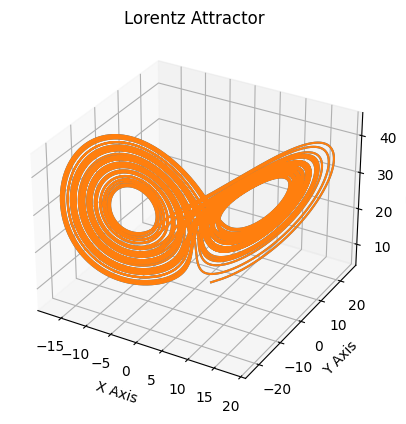

In [ ]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot(*hist.T)
ax.plot(*hist.T)
ax.set_title('Lorentz Attractor')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')


16.130565334288644
19.362869421752944
40.48096259946261
1.0597390949467813
0.6323840617208718
22.162136623476293


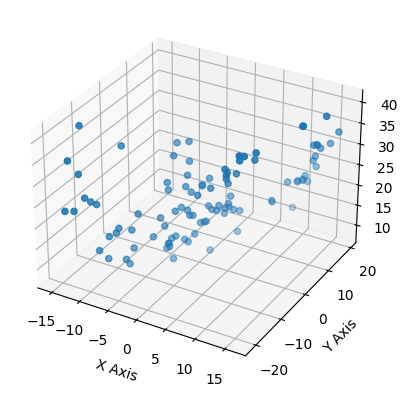

In [ ]:
starting_coords = np.random.randint(5 * int(1/dt), hist.shape[0], 100)
starting_coords = hist[starting_coords]
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*starting_coords.T)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
print(max(starting_coords[:,0]))
print(max(starting_coords[:,1]))
print(max(starting_coords[:,2]))
print(np.mean(starting_coords[:,0]))
print(np.mean(starting_coords[:,1]))
print(np.mean(starting_coords[:,2]))

In [ ]:
exponents = find_distances(starting_coords)

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
         7.,  8., 20., 11., 16., 19., 15.]),
 array([0.52948663, 0.55300476, 0.57652288, 0.600041  , 0.62355912,
        0.64707724, 0.67059536, 0.69411348, 0.7176316 , 0.74114972,
        0.76466785, 0.78818597, 0.81170409, 0.83522221, 0.85874033,
        0.88225845, 0.90577657, 0.92929469, 0.95281281, 0.97633094,
        0.99984906]),
 <BarContainer object of 20 artists>)

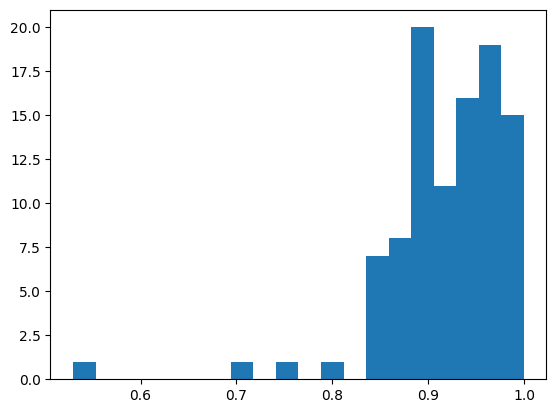

In [ ]:
plt.figure(3)
for i in range(len(exponents)):
    if exponents[i] is None:
        exponents[i] = -1
plt.hist(exponents, bins=20)

Text(0, 0.5, 'Exponent')

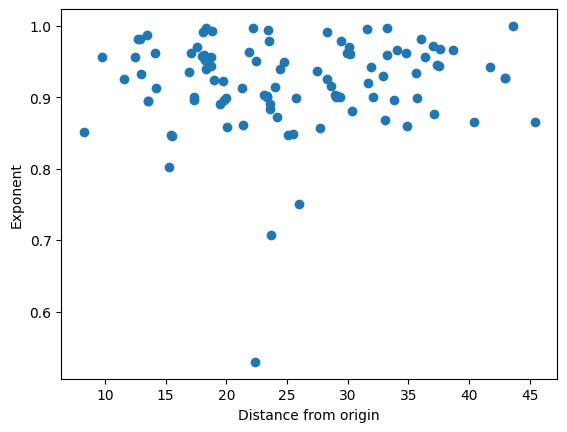

In [ ]:

xs = []

for i, exponent in enumerate(exponents):
    coord = starting_coords[i] 
    distance_from_origin = np.sqrt(sum([c ** 2 for c in coord]))
    xs.append(distance_from_origin)

plt.figure(5)
plt.scatter(xs, exponents)
plt.xlabel('Distance from origin')
plt.ylabel('Exponent')

In [ ]:
np.mean(exponents)

0.9197530553866216